# Customer Intent Recognition

## Check System Environment

In [ ]:
!nvidia-smi

In [ ]:
# Check GPU Info
!cat /proc/cpuinfo

In [ ]:
!pip list

In [ ]:
# Check System Version
!cat /etc/os-release

## Download Dataset

In [ ]:
!kaggle datasets download scodepy/customer-support-intent-dataset

In [ ]:
!unzip /content/customer-support-intent-dataset.zip

## Import Libraries

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import Adam

## Prepare dataset

In [10]:
pd_data = pd.read_csv('/content/Bitext_Sample_Customer_Service_Testing_Dataset.csv').sample(frac=1).reset_index(drop=True)
pd_data.head()

,utterance,intent,category,tags
0,can you help me to subscribe to your corporate...,newsletter_subscription,NEWSLETTER,BIL
1,assistance changing the shipping address,change_shipping_address,SHIPPING_ADDRESS,B
2,how do i remove my online account,delete_account,ACCOUNT,BILQ
3,check invoices from last month,check_invoice,INVOICE,BKM
4,I want assistance to change my shipping address,change_shipping_address,SHIPPING_ADDRESS,B


In [11]:
pd_data.shape

(818, 4)

In [12]:
pd_data['category'].value_counts()

,count
category,
ACCOUNT,172
ORDER,125
REFUND,93
SHIPPING_ADDRESS,73
DELIVERY,70
CONTACT,66
INVOICE,62
FEEDBACK,55
PAYMENT,53


In [13]:
def get_len(item):
  return len(item.split(' '))

pd_data['len'] = pd_data['utterance'].astype('str').map(get_len)
pd_data.head()

,utterance,intent,category,tags,len
0,can you help me to subscribe to your corporate...,newsletter_subscription,NEWSLETTER,BIL,10
1,assistance changing the shipping address,change_shipping_address,SHIPPING_ADDRESS,B,5
2,how do i remove my online account,delete_account,ACCOUNT,BILQ,7
3,check invoices from last month,check_invoice,INVOICE,BKM,5
4,I want assistance to change my shipping address,change_shipping_address,SHIPPING_ADDRESS,B,8


In [14]:
le = LabelEncoder()
pd_data['label'] = le.fit_transform(pd_data['category'])
print(pd_data.shape)
pd_data.head()


(818, 6)


,utterance,intent,category,tags,len,label
0,can you help me to subscribe to your corporate...,newsletter_subscription,NEWSLETTER,BIL,10,6
1,assistance changing the shipping address,change_shipping_address,SHIPPING_ADDRESS,B,5,10
2,how do i remove my online account,delete_account,ACCOUNT,BILQ,7,0
3,check invoices from last month,check_invoice,INVOICE,BKM,5,5
4,I want assistance to change my shipping address,change_shipping_address,SHIPPING_ADDRESS,B,8,10


In [15]:
le.classes_

array(['ACCOUNT', 'CANCELLATION_FEE', 'CONTACT', 'DELIVERY', 'FEEDBACK',
       'INVOICE', 'NEWSLETTER', 'ORDER', 'PAYMENT', 'REFUND',
       'SHIPPING_ADDRESS'], dtype=object)

In [16]:
pd_test = pd.read_csv('/content/Bitext_Sample_Customer_Service_Validation_Dataset.csv')
print(pd_test.shape)
pd_test.head()

(818, 4)


,utterance,intent,category,tags
0,I want help to cancel the order I have made,cancel_order,ORDER,B
1,where can I get information about order cancel...,cancel_order,ORDER,BIM
2,help to cancel the last order,cancel_order,ORDER,B
3,I need help with canceling an order I made,cancel_order,ORDER,B
4,I do not know how I can cancel the order I made,cancel_order,ORDER,BE


In [17]:
pd_test['label'] = le.transform(pd_test['category'])
pd_test.head()

,utterance,intent,category,tags,label
0,I want help to cancel the order I have made,cancel_order,ORDER,B,7
1,where can I get information about order cancel...,cancel_order,ORDER,BIM,7
2,help to cancel the last order,cancel_order,ORDER,B,7
3,I need help with canceling an order I made,cancel_order,ORDER,B,7
4,I do not know how I can cancel the order I made,cancel_order,ORDER,BE,7


In [18]:
le.classes_, len(le.classes_)

(array(['ACCOUNT', 'CANCELLATION_FEE', 'CONTACT', 'DELIVERY', 'FEEDBACK',
        'INVOICE', 'NEWSLETTER', 'ORDER', 'PAYMENT', 'REFUND',
        'SHIPPING_ADDRESS'], dtype=object),
 11)

<Axes: >

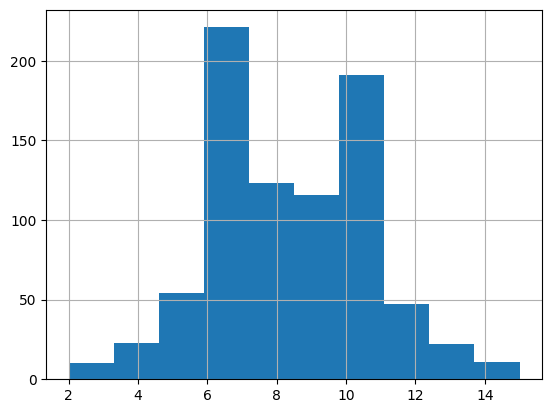

In [19]:
pd_data['len'].hist()

## Hyperparameter Setting

In [20]:
max_len = 25
n_class = 11

In [ ]:
name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(name)
# model = AutoModelForSequenceClassification.from_pretrained(name)

## Prepare Tokenizer and Model

In [ ]:
tokenizer.vocab

In [ ]:
voc_size = len(tokenizer.vocab)
voc_size

## Related Functions

### Visualization of Training Process

In [24]:

def plot_acc_loss(train_acc_list,test_acc_list,train_loss_list,test_loss_list):
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
    acc = train_acc_list
    val_acc = test_acc_list

    loss = train_loss_list
    val_loss = test_loss_list
    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def get_predict_score(model, test_dl):
    predict_list = []
    label_list = []
    predict_pro_list = []
    m_softmax = nn.Softmax(dim=1)
    model.eval()
    for (b_text, y) in test_dl:
        b_text, y = b_text.to(device), y.to(device)

        predict_score = model(b_text)
        predict_pro = m_softmax(predict_score)
        predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

        predict_pro_list.append(predict_pro.detach().cpu().numpy())
        predict_list.append(predict_label)
        label_list.append(y.detach().cpu().numpy())

    predict_pro_array = np.vstack(predict_pro_list)[:,1]
    predict_array = np.hstack(predict_list)
    label_array = np.hstack(label_list)
    # predict_pro_array[:5],predict_array[:5],label_array[:5]
    return predict_pro_array,predict_array,label_array


def train_test_epoch(train_dl,test_dl, model, loss_fn, optimizer,epochs):
    # epochs = 2
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dl, model, loss_fn, optimizer)

        train_loss, train_correct = test(train_dl, model, loss_fn)
        test_loss, test_correct = test(test_dl, model, loss_fn)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_correct)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_correct)

    print("Done!")
    return train_loss_list,train_acc_list,test_loss_list,test_acc_list

### Prepare Training and Testing Loops

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y) in dataloader:
            X = X.to(device)

            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

## Data Processing Pipeline

### Tokenization

In [26]:
text_eg = 'i feel good'

inputs = tokenizer(text_eg, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 1045, 2514, 2204,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])}

### Custom Dataset

In [27]:
pd_data.head()

,utterance,intent,category,tags,len,label
0,can you help me to subscribe to your corporate...,newsletter_subscription,NEWSLETTER,BIL,10,6
1,assistance changing the shipping address,change_shipping_address,SHIPPING_ADDRESS,B,5,10
2,how do i remove my online account,delete_account,ACCOUNT,BILQ,7,0
3,check invoices from last month,check_invoice,INVOICE,BKM,5,5
4,I want assistance to change my shipping address,change_shipping_address,SHIPPING_ADDRESS,B,8,10


In [28]:
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.nn import  functional as F

class CustomDataset(Dataset):
    def __init__(self, pd_data,tokenizer):
        self.pd_data = pd_data
        self.text_list = list(pd_data['utterance'].astype('str'))
        self.label_list = list(pd_data['label'])
        self.tokenizer = tokenizer

    def __len__(self):
        # return len(self.label_list)
        return len(self.pd_data)

    def __getitem__(self, idx):
        one_text = self.text_list[idx]
        # print(one_text)
        one_result = self.tokenizer(one_text,padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")
        # print(one_result)
        one_ids = one_result.input_ids[0]
        one_attention_mask = one_result.attention_mask

        one_label = self.label_list[idx]
        one_label = torch.tensor(one_label).long()
        return one_ids, one_label

In [29]:
train_ds = CustomDataset(pd_data,tokenizer)
test_ds = CustomDataset(pd_test,tokenizer)

In [30]:
# all_ds = CustomDataset(pd_data,tokenizer)
# # _, train_ds, test_ds = torch.utils.data.random_split(all_ds, [0.98,0.016, 0.004])
# train_ds, test_ds = torch.utils.data.random_split(all_ds, [0.8,0.2])
train_ds[1],len(train_ds),len(test_ds)

((tensor([ 101, 5375, 5278, 1996, 7829, 4769,  102,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0]),
  tensor(10)),
 818,
 818)

In [31]:
test_ds[0]

(tensor([  101,  1045,  2215,  2393,  2000, 17542,  1996,  2344,  1045,  2031,
          2081,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]),
 tensor(7))

## Prepare Dataloader

In [32]:

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8)

In [33]:
# for text_b,label in test_dl:
for text_b,label in train_dl:
  print(text_b.shape)
  print(label)
  break

torch.Size([8, 25])
tensor([7, 7, 3, 4, 7, 1, 9, 7])


## Confirm GPU/CPU Usage

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

## textCNN model

### Model Construction

In [35]:
class textCNN(nn.Module):
    def __init__(self,):
        super().__init__()
        emb_dim = 100
        # n_class = 4
        kernels=[3,4,5]
        kernel_number=[150,150,150]
        self.embd = nn.Embedding(voc_size, emb_dim)
        self.convs = nn.ModuleList([nn.Conv1d(max_len, number, size,padding=size) for (size,number) in zip(kernels,kernel_number)])
        self.dropout=nn.Dropout(0.1)
        self.lin = nn.Linear(sum(kernel_number), 50)
        self.out = nn.Linear(50, n_class)

    def forward(self, x):
        x = self.embd(x)

        x = [F.relu(conv(x)) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.lin(x)

        x = self.out(x)
        return x
text_cnn = textCNN().to(device)
# text_cnn(text)[0].shape,text_cnn(text)[1].shape,text_cnn(text)[2].shape

text_cnn(text_b.to(device)).shape

torch.Size([8, 11])

### Prepare Loss Function and Optimzer

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_cnn.parameters(), lr=1e-3)

### Training and Evaluation

In [37]:
epochs = 5
train_loss_list,train_acc_list,test_loss_list,test_acc_list = train_test_epoch(train_dl, test_dl, text_cnn, loss_fn, optimizer,epochs)
train_loss_list,train_acc_list,test_loss_list,test_acc_list

Epoch 1
-------------------------------
loss: 2.773756  [    8/  818]
loss: 2.772299  [  408/  818]
loss: 2.160624  [  808/  818]
Test Error: 
 Accuracy: 21.5%, Avg loss: 2.260400 

Test Error: 
 Accuracy: 23.2%, Avg loss: 2.324227 

Epoch 2
-------------------------------
loss: 2.407942  [    8/  818]
loss: 1.908085  [  408/  818]
loss: 1.901379  [  808/  818]
Test Error: 
 Accuracy: 34.8%, Avg loss: 2.066658 

Test Error: 
 Accuracy: 26.2%, Avg loss: 2.217728 

Epoch 3
-------------------------------
loss: 2.061358  [    8/  818]
loss: 1.914111  [  408/  818]
loss: 2.479401  [  808/  818]
Test Error: 
 Accuracy: 35.0%, Avg loss: 1.955478 

Test Error: 
 Accuracy: 30.1%, Avg loss: 2.185087 

Epoch 4
-------------------------------
loss: 1.454423  [    8/  818]
loss: 1.305078  [  408/  818]
loss: 1.568263  [  808/  818]
Test Error: 
 Accuracy: 65.2%, Avg loss: 1.522501 

Test Error: 
 Accuracy: 48.9%, Avg loss: 1.893178 

Epoch 5
-------------------------------
loss: 1.759318  [    8/ 

([2.2604003299787205,
  2.0666576913259562,
  1.9554777145385742,
  1.522500888236518,
  1.2172325299781503],
 [0.21515892420537897,
  0.3484107579462103,
  0.34963325183374083,
  0.6515892420537898,
  0.7188264058679706],
 [2.324227237006993,
  2.2177277433062064,
  2.1850873515443894,
  1.8931779514238671,
  1.6718836834708464],
 [0.23227383863080683,
  0.2616136919315403,
  0.30073349633251834,
  0.4889975550122249,
  0.5672371638141809])

### Visualize Training Process

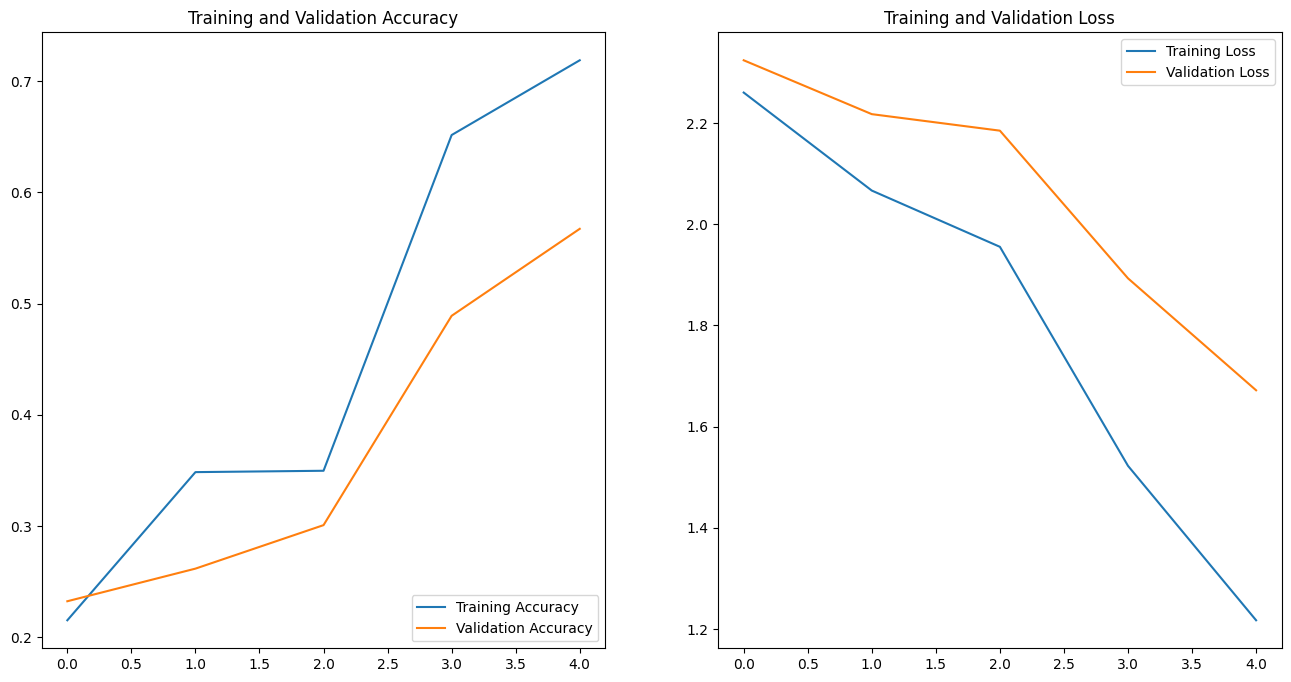

In [38]:
plot_acc_loss(train_acc_list,test_acc_list,train_loss_list,test_loss_list)

### Statistical Analysis

In [39]:
# predict_list = []
# label_list = []
# predict_pro_list = []
# m_softmax = nn.Softmax(dim=1)
# for (text_ids, y) in test_dl:
#     text_ids = text_ids.to(device)
#     y = y.to(device)

#     predict_score = text_cnn(text_ids)
#     predict_pro = m_softmax(predict_score)
#     predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

#     predict_pro_list.append(predict_pro.detach().cpu().numpy())
#     predict_list.append(predict_label)
#     label_list.append(y.detach().cpu().numpy())

# predict_pro_array = np.vstack(predict_pro_list)[:,1]
# predict_array = np.hstack(predict_list)
# label_array = np.hstack(label_list)
# predict_pro_array[:5],predict_array[:5],label_array[:5]

In [40]:
predict_pro_array,predict_array,label_array = get_predict_score(text_cnn, test_dl)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.00337804, 0.00698343, 0.01446192, 0.00844626, 0.01891789],
       dtype=float32),
 array([7, 7, 7, 7, 7]),
 array([7, 7, 7, 7, 7]))

#### Classification Report

In [41]:
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.515     0.711     0.597       190
           1      0.000     0.000     0.000        26
           2      0.000     0.000     0.000        52
           3      0.623     0.787     0.696        61
           4      0.000     0.000     0.000        58
           5      0.559     0.867     0.680        60
           6      0.000     0.000     0.000        34
           7      0.465     0.729     0.568       129
           8      0.690     0.345     0.460        58
           9      0.807     0.763     0.785        93
          10      0.657     0.772     0.710        57

    accuracy                          0.567       818
   macro avg      0.392     0.452     0.409       818
weighted avg      0.467     0.567     0.501       818



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Confusion Matrix

In [42]:
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[135,   0,   0,   0,   0,   3,   0,  40,   1,   2,   9],
       [  8,   0,   0,   1,   0,   2,   0,  10,   0,   4,   1],
       [ 28,   0,   0,   2,   0,   5,   0,  13,   2,   2,   0],
       [  0,   0,   0,  48,   0,   2,   0,  11,   0,   0,   0],
       [ 20,   0,   0,  11,   0,   5,   0,   9,   1,   5,   7],
       [  4,   0,   0,   0,   0,  52,   0,   2,   0,   0,   2],
       [ 15,   0,   0,   0,   0,  13,   0,   2,   2,   1,   1],
       [ 23,   0,   0,   5,   0,   4,   0,  94,   2,   1,   0],
       [ 14,   0,   0,   8,   0,   1,   0,  12,  20,   1,   2],
       [  7,   0,   0,   2,   0,   6,   0,   5,   1,  71,   1],
       [  8,   0,   0,   0,   0,   0,   0,   4,   0,   1,  44]])

<Axes: >

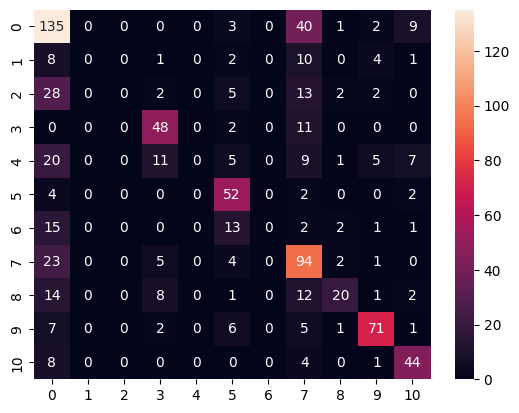

In [43]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

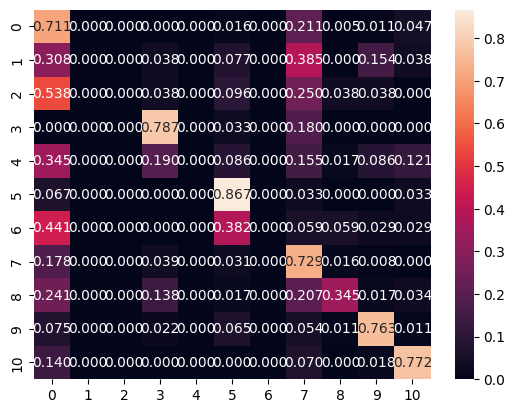

In [44]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

## LSTM Model

### Model Construction

In [45]:
class LSTMModel(nn.Module):
    def __init__(self,):
        super().__init__()
        emb_dim = 100
        self.embd = nn.Embedding(voc_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim,50,batch_first=True)
        self.out = nn.Linear(100, n_class)
        self.flatten = nn.Flatten()
        self.lin = nn.Linear(1250, 100)

    def forward(self, x):
        x = self.embd(x)

        x,_ = self.lstm(x)

        x = self.flatten(x)
        x = self.lin(x)
        x = F.relu(x)
        x = self.out(x)
        return x
lstm_model = LSTMModel().to(device)


lstm_model(text_b.to(device)).shape

torch.Size([8, 11])

### Prepare Loss Function and Optimizer

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

### Training and Evaluation

In [47]:
epochs = 5
train_loss_list,train_acc_list,test_loss_list,test_acc_list = train_test_epoch(train_dl, test_dl, lstm_model, loss_fn, optimizer,epochs)
train_loss_list,train_acc_list,test_loss_list,test_acc_list

Epoch 1
-------------------------------
loss: 2.400295  [    8/  818]
loss: 1.849665  [  408/  818]
loss: 1.344818  [  808/  818]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.855890 

Test Error: 
 Accuracy: 76.2%, Avg loss: 0.925412 

Epoch 2
-------------------------------
loss: 0.868979  [    8/  818]
loss: 0.124487  [  408/  818]
loss: 0.007261  [  808/  818]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.059805 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.118116 

Epoch 3
-------------------------------
loss: 0.023663  [    8/  818]
loss: 0.039674  [  408/  818]
loss: 0.002696  [  808/  818]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006602 

Test Error: 
 Accuracy: 98.7%, Avg loss: 0.053718 

Epoch 4
-------------------------------
loss: 0.003120  [    8/  818]
loss: 0.000747  [  408/  818]
loss: 0.001003  [  808/  818]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001802 

Test Error: 
 Accuracy: 98.8%, Avg loss: 0.043259 

Epoch 5
-------------------------------
loss: 0.000718  [    8

([0.8558903501450437,
  0.05980459618318862,
  0.0066017554779039716,
  0.0018020982690041352,
  0.0011752600839120806],
 [0.7995110024449877, 0.9926650366748166, 1.0, 1.0, 1.0],
 [0.925412199450928,
  0.1181161414608088,
  0.053717853910835334,
  0.04325880261149879,
  0.04093055638337689],
 [0.7616136919315404,
  0.9645476772616137,
  0.9865525672371638,
  0.9877750611246944,
  0.9877750611246944])

### Visualize the Training Process

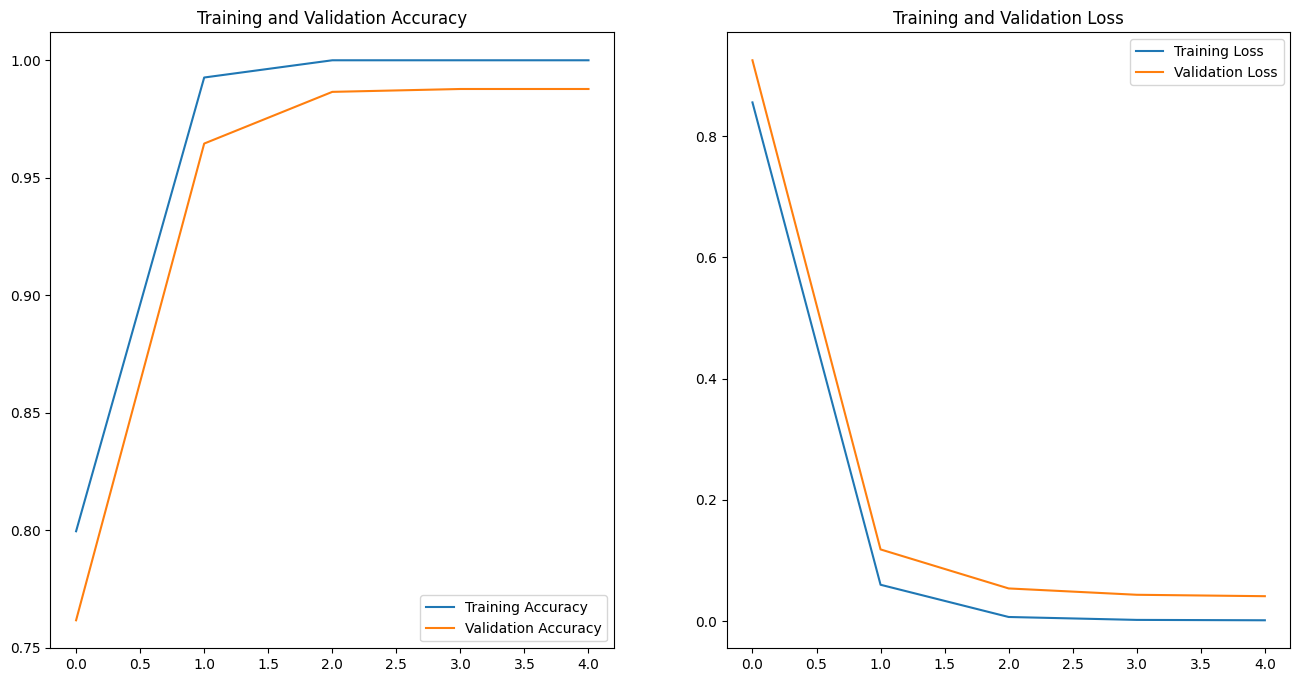

In [48]:
plot_acc_loss(train_acc_list,test_acc_list,train_loss_list,test_loss_list)

### Statistical Analysis

In [49]:
# predict_list = []
# label_list = []
# predict_pro_list = []
# m_softmax = nn.Softmax(dim=1)
# for (text_ids, y) in test_dl:
#     text_ids = text_ids.to(device)
#     y = y.to(device)

#     predict_score = lstm_model(text_ids)
#     predict_pro = m_softmax(predict_score)
#     predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

#     predict_pro_list.append(predict_pro.detach().cpu().numpy())
#     predict_list.append(predict_label)
#     label_list.append(y.detach().cpu().numpy())

# predict_pro_array = np.vstack(predict_pro_list)[:,1]
# predict_array = np.hstack(predict_list)
# label_array = np.hstack(label_list)
# predict_pro_array[:5],predict_array[:5],label_array[:5]

In [50]:
predict_pro_array,predict_array,label_array = get_predict_score(lstm_model, test_dl)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([1.5393969e-07, 8.5535908e-07, 6.6250516e-09, 1.6132933e-08,
        3.7140646e-06], dtype=float32),
 array([7, 7, 7, 7, 7]),
 array([7, 7, 7, 7, 7]))

#### Classification Report

In [51]:
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.979     0.979     0.979       190
           1      1.000     0.962     0.980        26
           2      0.962     0.981     0.971        52
           3      1.000     1.000     1.000        61
           4      0.951     1.000     0.975        58
           5      1.000     1.000     1.000        60
           6      1.000     0.971     0.985        34
           7      0.992     1.000     0.996       129
           8      1.000     0.983     0.991        58
           9      1.000     0.978     0.989        93
          10      1.000     1.000     1.000        57

    accuracy                          0.988       818
   macro avg      0.989     0.987     0.988       818
weighted avg      0.988     0.988     0.988       818



#### Confusion Matrix

In [52]:
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[186,   0,   1,   0,   2,   0,   0,   1,   0,   0,   0],
       [  1,  25,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,  51,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  61,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  58,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  60,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,  33,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 129,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,  57,   0,   0],
       [  1,   0,   1,   0,   0,   0,   0,   0,   0,  91,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  57]])

<Axes: >

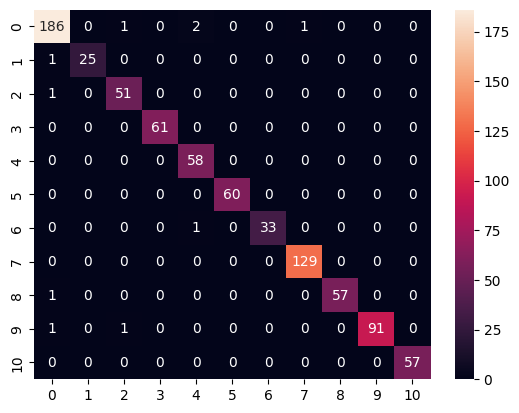

In [53]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

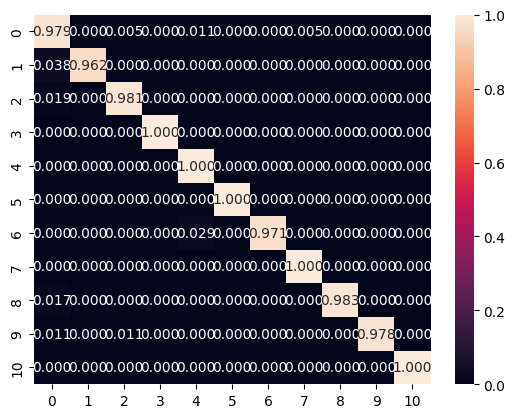

In [54]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

## Transformer Model

### Model Construction

In [55]:
class TransformerModel(nn.Module):
    def __init__(self,):
        super().__init__()
        emb_dim = 100
        self.embd = nn.Embedding(voc_size, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=2,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.out = nn.Linear(2500, n_class)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.embd(x)

        x= self.transformer_encoder(x)
        x = self.flatten(x)
        x = self.out(x)
        return x
transformer_model = TransformerModel().to(device)
# text_cnn(text)[0].shape,text_cnn(text)[1].shape,text_cnn(text)[2].shape

transformer_model(text_b.to(device)).shape

torch.Size([8, 11])

### Loss Function and Optimizer

In [56]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=2e-5)

### Training and Evaluation

In [57]:
epochs = 10
train_loss_list,train_acc_list,test_loss_list,test_acc_list = train_test_epoch(train_dl, test_dl, transformer_model, loss_fn, optimizer,epochs)
train_loss_list,train_acc_list,test_loss_list,test_acc_list

Epoch 1
-------------------------------
loss: 2.699450  [    8/  818]
loss: 2.251994  [  408/  818]
loss: 2.586849  [  808/  818]
Test Error: 
 Accuracy: 25.2%, Avg loss: 2.092775 

Test Error: 
 Accuracy: 27.0%, Avg loss: 2.143494 

Epoch 2
-------------------------------
loss: 1.765546  [    8/  818]
loss: 1.989805  [  408/  818]
loss: 1.972410  [  808/  818]
Test Error: 
 Accuracy: 36.7%, Avg loss: 1.868131 

Test Error: 
 Accuracy: 32.5%, Avg loss: 1.974861 

Epoch 3
-------------------------------
loss: 1.412164  [    8/  818]
loss: 1.459773  [  408/  818]
loss: 1.822253  [  808/  818]
Test Error: 
 Accuracy: 58.1%, Avg loss: 1.499161 

Test Error: 
 Accuracy: 51.5%, Avg loss: 1.641212 

Epoch 4
-------------------------------
loss: 1.572692  [    8/  818]
loss: 1.317788  [  408/  818]
loss: 1.561231  [  808/  818]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.943929 

Test Error: 
 Accuracy: 73.2%, Avg loss: 1.084217 

Epoch 5
-------------------------------
loss: 0.770131  [    8/ 

([2.09277510411531,
  1.8681306665383497,
  1.49916077817528,
  0.9439294433709488,
  0.6053436184392392,
  0.40028794883813673,
  0.2622823496394366,
  0.18780748591333338,
  0.14131278568173497,
  0.1052472335693327],
 [0.25183374083129584,
  0.36674816625916873,
  0.5806845965770171,
  0.784841075794621,
  0.8545232273838631,
  0.921760391198044,
  0.9547677261613692,
  0.9669926650366748,
  0.9767726161369193,
  0.9853300733496333],
 [2.143494337507822,
  1.9748610663182526,
  1.6412124628002205,
  1.0842169514558848,
  0.7232588702469196,
  0.503114490905433,
  0.3593472141808676,
  0.2725981882077108,
  0.23068963329407197,
  0.18384752880998897],
 [0.2701711491442543,
  0.3251833740831296,
  0.5146699266503667,
  0.7322738386308069,
  0.812958435207824,
  0.8789731051344744,
  0.921760391198044,
  0.9388753056234719,
  0.9437652811735942,
  0.9498777506112469])

### Visualization of Training Process

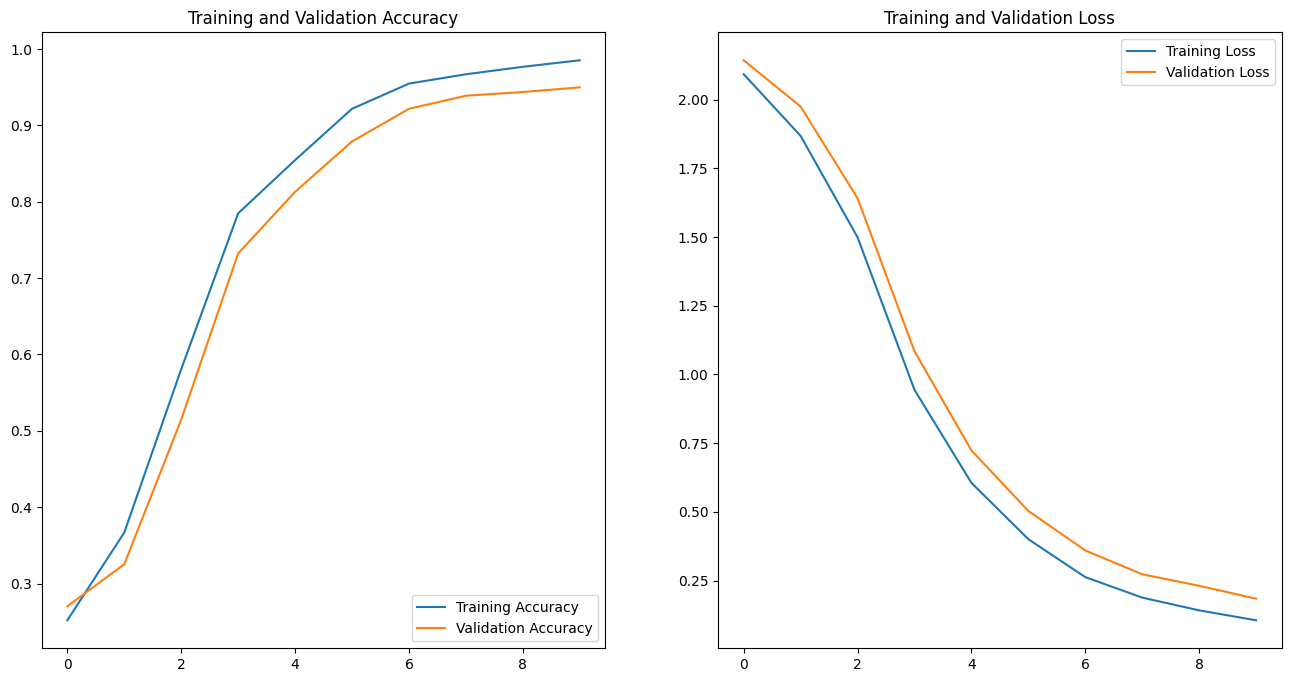

In [58]:
plot_acc_loss(train_acc_list,test_acc_list,train_loss_list,test_loss_list)

### Statistical Analysis

In [59]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (text_ids, y) in test_dl:
    text_ids = text_ids.to(device)
    y = y.to(device)

    predict_score = transformer_model(text_ids)
    predict_pro = m_softmax(predict_score)
    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.00067092, 0.00028187, 0.00181244, 0.00018676, 0.00325319],
       dtype=float32),
 array([7, 7, 7, 7, 7]),
 array([7, 7, 7, 7, 7]))

In [60]:
predict_pro_array,predict_array,label_array = get_predict_score(transformer_model, test_dl)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.00067092, 0.00028187, 0.00181244, 0.00018676, 0.00325319],
       dtype=float32),
 array([7, 7, 7, 7, 7]),
 array([7, 7, 7, 7, 7]))

#### Classification Report

In [61]:
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.923     0.953     0.938       190
           1      0.862     0.962     0.909        26
           2      0.828     0.923     0.873        52
           3      1.000     0.934     0.966        61
           4      0.889     0.828     0.857        58
           5      1.000     1.000     1.000        60
           6      1.000     0.971     0.985        34
           7      0.952     0.930     0.941       129
           8      1.000     0.966     0.982        58
           9      1.000     0.989     0.995        93
          10      1.000     1.000     1.000        57

    accuracy                          0.950       818
   macro avg      0.950     0.950     0.950       818
weighted avg      0.951     0.950     0.950       818



#### Confusion Matrix

In [62]:
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[181,   0,   4,   0,   2,   0,   0,   3,   0,   0,   0],
       [  1,  25,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,  48,   0,   3,   0,   0,   0,   0,   0,   0],
       [  0,   4,   0,  57,   0,   0,   0,   0,   0,   0,   0],
       [  6,   0,   1,   0,  48,   0,   0,   3,   0,   0,   0],
       [  0,   0,   0,   0,   0,  60,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,  33,   0,   0,   0,   0],
       [  5,   0,   3,   0,   1,   0,   0, 120,   0,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   0,  56,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,  92,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  57]])

<Axes: >

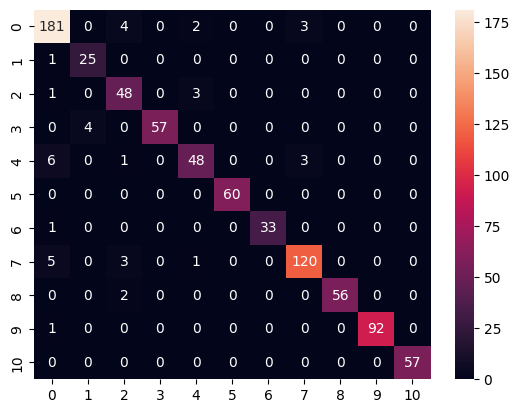

In [63]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

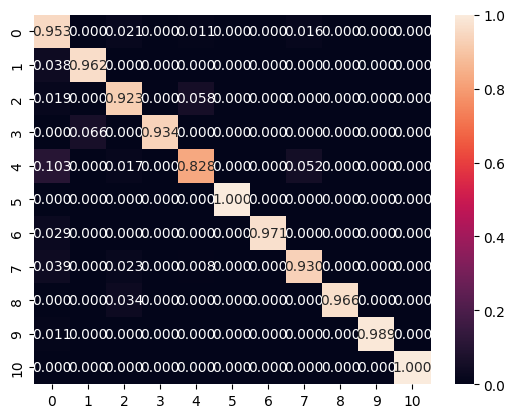

In [64]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

## BERT Model

### Prepare Model Block

In [65]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_block = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=n_class).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
class bertModel(nn.Module):
    def __init__(self,):
        super().__init__()
        self.bert_block = model_block

    def forward(self, text_b):
        x = self.bert_block(text_b)
        return x.logits
bert_model = bertModel().to(device)

bert_model(text_b.to(device))

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 0.5365,  0.0868,  0.2230,  0.0389, -0.2534, -0.1196, -0.2424, -0.0795,
          0.1492,  0.1529, -0.2498],
        [ 0.5614,  0.1507,  0.2297,  0.0173, -0.2744, -0.0741, -0.2628, -0.0904,
          0.1153,  0.1173, -0.2361],
        [ 0.4802,  0.1483,  0.2139,  0.0082, -0.2145, -0.0650, -0.2926, -0.0663,
          0.1214,  0.0628, -0.2514],
        [ 0.6258,  0.1130,  0.2343,  0.0781, -0.2976, -0.1231, -0.2025, -0.0914,
          0.1112,  0.2332, -0.2635],
        [ 0.5978,  0.1702,  0.2207,  0.0028, -0.3082, -0.1129, -0.2282, -0.0786,
          0.1223,  0.1756, -0.2254],
        [ 0.5527,  0.1743,  0.2546, -0.0151, -0.2698, -0.0502, -0.2673, -0.0892,
          0.1311, -0.0143, -0.2732],
        [ 0.5765,  0.1244,  0.2475, -0.0100, -0.2727, -0.0523, -0.2531, -0.0901,
          0.1588,  0.0398, -0.2820],
        [ 0.5575,  0.2095,  0.2333, -0.0012, -0.3202, -0.1634, -0.2557, -0.1089,
          0.0529,  0.1944, -0.1867]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### Loss Function and Optimizer

In [67]:

# optimizer = AdamW(bert_model.parameters(), lr=2e-5)

optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5)
# optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

### Model Training and Evaluation

In [68]:
epochs = 5
train_loss_list,train_acc_list,test_loss_list,test_acc_list = train_test_epoch(train_dl, test_dl, bert_model, loss_fn, optimizer,epochs)
train_loss_list,train_acc_list,test_loss_list,test_acc_list

Epoch 1
-------------------------------
loss: 2.357380  [    8/  818]
loss: 1.858477  [  408/  818]
loss: 1.559271  [  808/  818]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.964047 

Test Error: 
 Accuracy: 85.3%, Avg loss: 0.977743 

Epoch 2
-------------------------------
loss: 1.070647  [    8/  818]
loss: 0.744943  [  408/  818]
loss: 0.202670  [  808/  818]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.205960 

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.223234 

Epoch 3
-------------------------------
loss: 0.281299  [    8/  818]
loss: 0.204743  [  408/  818]
loss: 0.133264  [  808/  818]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.074066 

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.084980 

Epoch 4
-------------------------------
loss: 0.070972  [    8/  818]
loss: 0.071820  [  408/  818]
loss: 0.047357  [  808/  818]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.041322 

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.050011 

Epoch 5
-------------------------------
loss: 0.053002  [    

([0.9640465199368672,
  0.20595964196237546,
  0.07406632182667557,
  0.04132150972569452,
  0.027186827390518004],
 [0.8801955990220048, 1.0, 1.0, 1.0, 1.0],
 [0.9777427975413868,
  0.22323429714707496,
  0.08497989014948457,
  0.050011121080193705,
  0.035105833349731365],
 [0.8533007334963325,
  0.9987775061124694,
  0.9975550122249389,
  0.9975550122249389,
  0.9975550122249389])

### Visualization of the Training Process

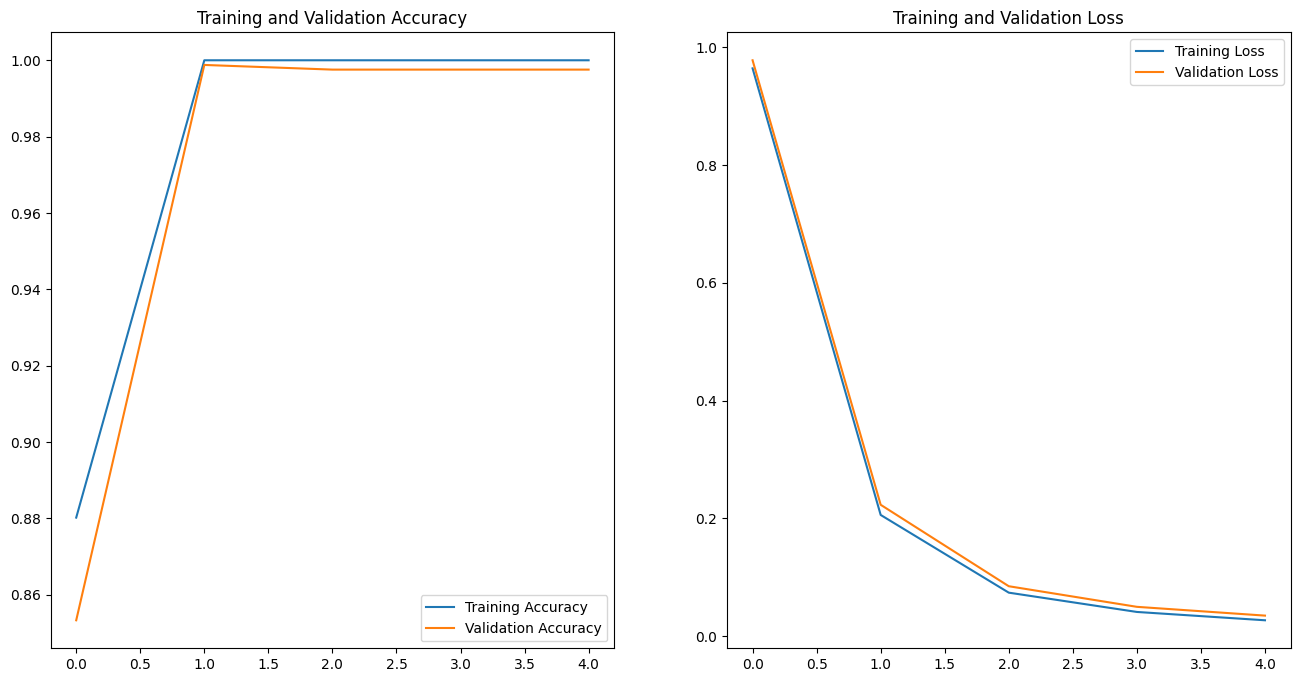

In [69]:
plot_acc_loss(train_acc_list,test_acc_list,train_loss_list,test_loss_list)

### Model Prediction

In [70]:
predict_pro_array,predict_array,label_array = get_predict_score(bert_model, test_dl)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.00155603, 0.00263459, 0.00161335, 0.00149411, 0.00153055],
       dtype=float32),
 array([7, 7, 7, 7, 7]),
 array([7, 7, 7, 7, 7]))

### Statistical Analysis

In [71]:
predict_pro_array,predict_array,label_array = get_predict_score(bert_model, test_dl)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.00155603, 0.00263459, 0.00161335, 0.00149411, 0.00153055],
       dtype=float32),
 array([7, 7, 7, 7, 7]),
 array([7, 7, 7, 7, 7]))

#### Classification Report

In [72]:
print(classification_report(label_array, predict_array, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.995     0.997       190
           1      1.000     1.000     1.000        26
           2      1.000     1.000     1.000        52
           3      1.000     1.000     1.000        61
           4      1.000     1.000     1.000        58
           5      1.000     1.000     1.000        60
           6      1.000     1.000     1.000        34
           7      0.992     1.000     0.996       129
           8      0.983     1.000     0.991        58
           9      1.000     0.989     0.995        93
          10      1.000     1.000     1.000        57

    accuracy                          0.998       818
   macro avg      0.998     0.999     0.998       818
weighted avg      0.998     0.998     0.998       818



#### Confusion Matrix

<Axes: >

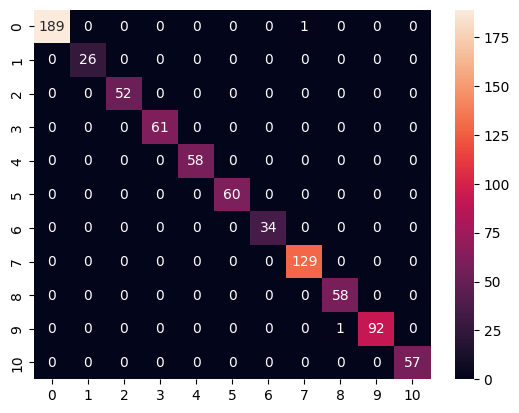

In [73]:
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

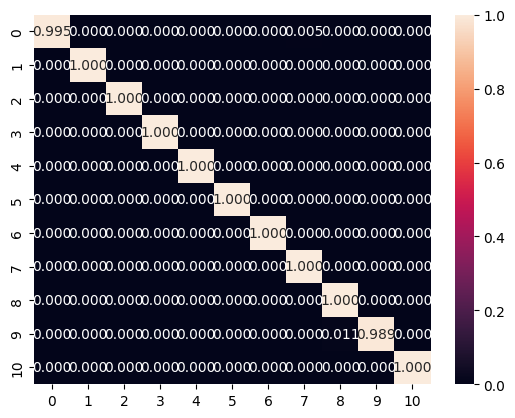

In [74]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

## Combined Model: CNN+LSTM+BERT

### Prepare Models

In [75]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model_block = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

In [76]:
voc_size = len(tokenizer.vocab)
voc_size

30522

#### Attention Module

In [77]:
import math
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        # '-1' means last dimension.

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out


class ScaleDotProductAttention(nn.Module):
    """
    compute scale dot product attention

    Query : given sentence that we focused on (decoder)
    Key : every sentence to check relationship with Qeury(encoder)
    Value : every sentence same with Key (encoder)
    """

    def __init__(self):
        super(ScaleDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None, e=1e-12):
        # input is 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. dot product Query with Key^T to compute similarity
        k_t = k.transpose(2, 3)  # transpose
        score = (q @ k_t) / math.sqrt(d_tensor)  # scaled dot product

        # 2. apply masking (opt)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)

        # 3. pass them softmax to make [0, 1] range
        score = self.softmax(score)

        # 4. multiply with Value
        v = score @ v

        return v, score

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, mask=mask)

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        # 5. visualize attention map
        # TODO : we should implement visualization

        return out

    def split(self, tensor):
        """
        split tensor by number of head

        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)
        # it is similar with group convolution (split by number of heads)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)

        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # 1. compute self attention
        _x = x
        x = self.attention(q=x, k=x, v=x, mask=None)

        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        # 3. positionwise feed forward network
        _x = x
        x = self.ffn(x)

        # 4. add and norm
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        return x

eg_tensor = torch.randn(32, 3, 100)
encoder_layer = EncoderLayer(d_model=100, ffn_hidden=200, n_head=2, drop_prob=0.1)
encoder_layer(eg_tensor).shape

torch.Size([32, 3, 100])

#### BERT Block

In [ ]:
class bertBlock(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model_block = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=100).to(device)

    def forward(self, text_b):
        x = self.model_block(text_b)
        return x.logits
bert_block = bertBlock().to(device)
# text_cnn(text)[0].shape,text_cnn(text)[1].shape,text_cnn(text)[2].shape

bert_block(text_b.to(device)).shape

#### textCNN Model Block

In [79]:
class textCNNblock(nn.Module):
    def __init__(self,):
        super().__init__()
        emb_dim = 100
        # n_class = 4
        kernels=[3,4,5]
        kernel_number=[150,150,150]
        self.embd = nn.Embedding(voc_size, emb_dim)
        self.convs = nn.ModuleList([nn.Conv1d(max_len, number, size,padding=size) for (size,number) in zip(kernels,kernel_number)])
        self.dropout=nn.Dropout(0.1)
        self.out = nn.Linear(sum(kernel_number), 100)

    def forward(self, x):
        x = self.embd(x)

        x = [F.relu(conv(x)) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.out(x)
        return x
text_cnn_block = textCNNblock().to(device)
# text_cnn(text)[0].shape,text_cnn(text)[1].shape,text_cnn(text)[2].shape

text_cnn_block(text_b.to(device)).shape

torch.Size([8, 100])

#### LSTM Model Block

In [80]:
class LSTMModelblock(nn.Module):
    def __init__(self,):
        super().__init__()
        emb_dim = 100
        # n_class = 2
        self.embd = nn.Embedding(voc_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim,50)
        self.out = nn.Linear(1250, 100)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.embd(x)

        x,_ = self.lstm(x)
        x = self.flatten(x)
        x = self.out(x)
        return x
lstm_model_block = LSTMModelblock().to(device)


lstm_model_block(text_b.to(device)).shape

torch.Size([8, 100])

### Combine the Big Model

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertModel

class BERT_CNN_LSTM(nn.Module):
    def __init__(self, ):
        super(BERT_CNN_LSTM, self).__init__()

        self.bert = bert_block
        self.lstm = lstm_model_block
        self.cnn = text_cnn_block
        self.fc1 = nn.Linear(300, 100)
        self.fc2 = nn.Linear(100, n_class)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

        self.att = EncoderLayer(d_model=100, ffn_hidden=200, n_head=2, drop_prob=0.1)
        self.flatten = nn.Flatten()

    def forward(self, input_ids):
        bert_out = self.bert(input_ids)
        lstm_out = self.lstm(input_ids)
        cnn_out = self.cnn(input_ids)

        x = torch.stack((bert_out,lstm_out, cnn_out), dim=1)
        x = self.att(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
# Create the model
model_big = BERT_CNN_LSTM()
model_big.to(device)

model_big(text_b.to(device)).shape

torch.Size([8, 11])

### Loss Function and Optimizer

In [82]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_big.parameters(), lr=2e-5)

### Training and Evaluation

In [83]:
epochs = 5
train_loss_list,train_acc_list,test_loss_list,test_acc_list = train_test_epoch(train_dl, test_dl, model_big, loss_fn, optimizer,epochs)
train_loss_list,train_acc_list,test_loss_list,test_acc_list

Epoch 1
-------------------------------
loss: 2.487865  [    8/  818]
loss: 2.129572  [  408/  818]
loss: 1.439224  [  808/  818]
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.617130 

Test Error: 
 Accuracy: 55.7%, Avg loss: 1.602618 

Epoch 2
-------------------------------
loss: 1.635020  [    8/  818]
loss: 1.588307  [  408/  818]
loss: 0.994379  [  808/  818]
Test Error: 
 Accuracy: 92.1%, Avg loss: 0.809609 

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.830355 

Epoch 3
-------------------------------
loss: 0.891851  [    8/  818]
loss: 0.710811  [  408/  818]
loss: 0.318515  [  808/  818]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.455497 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.475968 

Epoch 4
-------------------------------
loss: 0.408679  [    8/  818]
loss: 0.516704  [  408/  818]
loss: 0.303654  [  808/  818]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.296603 

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.314460 

Epoch 5
-------------------------------
loss: 0.277263  [    8/

([1.6171302610230678,
  0.8096090804025965,
  0.45549744280796606,
  0.29660271411960565,
  0.21031108006690313],
 [0.5378973105134475, 0.9205378973105135, 0.9951100244498777, 1.0, 1.0],
 [1.6026177446819045,
  0.8303554026247228,
  0.475967585172468,
  0.3144596322502905,
  0.22724758797478908],
 [0.5574572127139364,
  0.8924205378973105,
  0.9902200488997555,
  0.9975550122249389,
  0.9975550122249389])

### Visualize the Training Process

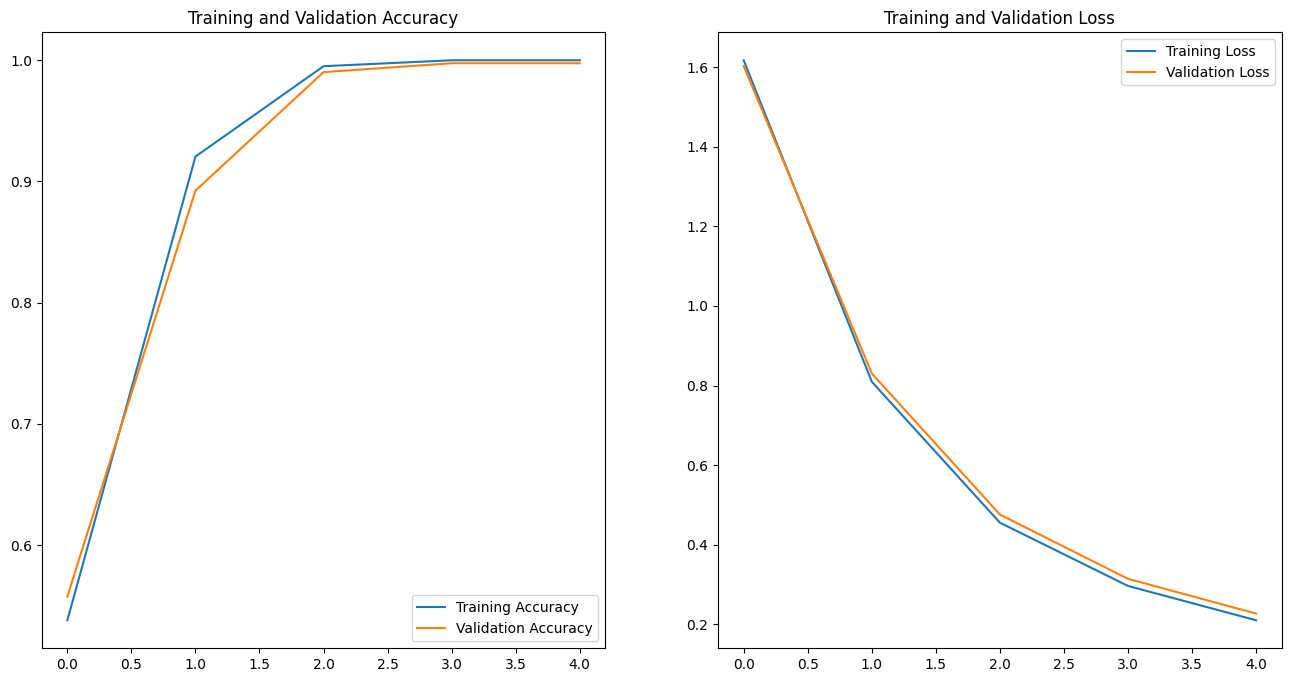

In [84]:
plot_acc_loss(train_acc_list,test_acc_list,train_loss_list,test_loss_list)

### Statistical Analysis

In [85]:
predict_pro_array,predict_array,label_array = get_predict_score(model_big, test_dl)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.00340886, 0.00465042, 0.00376885, 0.00351045, 0.00491737],
       dtype=float32),
 array([7, 7, 7, 7, 7]),
 array([7, 7, 7, 7, 7]))

#### Classification Report

In [86]:
print(classification_report(label_array, predict_array, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.995     0.997       190
           1      1.000     1.000     1.000        26
           2      1.000     1.000     1.000        52
           3      1.000     1.000     1.000        61
           4      0.983     1.000     0.991        58
           5      1.000     1.000     1.000        60
           6      1.000     1.000     1.000        34
           7      1.000     1.000     1.000       129
           8      0.983     1.000     0.991        58
           9      1.000     0.989     0.995        93
          10      1.000     1.000     1.000        57

    accuracy                          0.998       818
   macro avg      0.997     0.999     0.998       818
weighted avg      0.998     0.998     0.998       818



#### Confusion Matrix

<Axes: >

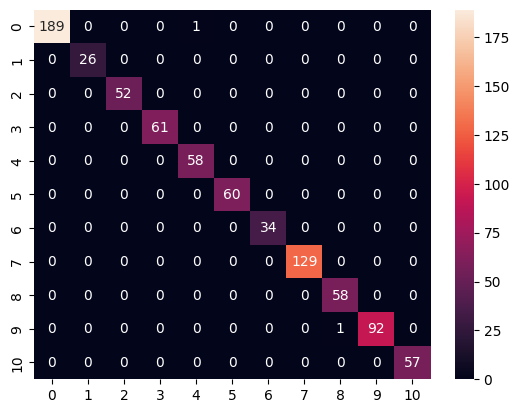

In [87]:
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

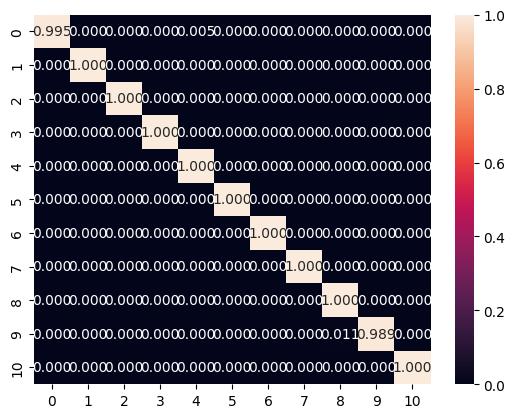

In [88]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

## Single Text Prediction


In [89]:
name_list = le.classes_
import json
name_list

array(['ACCOUNT', 'CANCELLATION_FEE', 'CONTACT', 'DELIVERY', 'FEEDBACK',
       'INVOICE', 'NEWSLETTER', 'ORDER', 'PAYMENT', 'REFUND',
       'SHIPPING_ADDRESS'], dtype=object)

In [90]:
pd_data.head()

,utterance,intent,category,tags,len,label
0,can you help me to subscribe to your corporate...,newsletter_subscription,NEWSLETTER,BIL,10,6
1,assistance changing the shipping address,change_shipping_address,SHIPPING_ADDRESS,B,5,10
2,how do i remove my online account,delete_account,ACCOUNT,BILQ,7,0
3,check invoices from last month,check_invoice,INVOICE,BKM,5,5
4,I want assistance to change my shipping address,change_shipping_address,SHIPPING_ADDRESS,B,8,10


In [ ]:
def predict(one_text,tokenizer, model):
  one_result = tokenizer(one_text,padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")
  # print(one_result)
  one_ids = one_result.input_ids[0]
  one_ids = one_ids.unsqueeze(0).to(device)

  # Use the model to predict
  with torch.no_grad():
      output = model(one_ids)
  # print(output)
  # compute the predicted probability
  pred_score = nn.functional.softmax(output[0], dim=0)
  pred_score = torch.max(pred_score).cpu().numpy()

  # obtain the predicted outcome
  pred_index = torch.argmax(output, dim=1).item()
  pred_label = name_list[pred_index]

  print(f"predict class name : {pred_label} \npredict score : {pred_score}")
  print(pred_index)
  # convert to json
  result_dict = {'pred_score':str(pred_score),'pred_index':str(pred_index),'pred_label':pred_label }
  result_json = json.dumps(result_dict)

  return result_json

eg_text = 'i feel good'
# eg_text = 'i feel so sad'
predict(eg_text,tokenizer,bert_model)

## Save Models

In [ ]:
def save_trained_models():
    """
    Save all the trained models for deployment on Hugging Face Spaces.
    Run this function at the end of your notebook after training.
    """
    print("Saving models...")

    # Save TextCNN model
    torch.save(text_cnn.state_dict(), 'cnn_intent_model.pth')
    print("TextCNN model saved as 'cnn_intent_model.pth'")

    # Save LSTM model
    torch.save(lstm_model.state_dict(), 'lstm_intent_model.pth')
    print("LSTM model saved as 'lstm_intent_model.pth'")

    # Save BERT model
    torch.save(bert_model.state_dict(), 'bert_intent_model.pth')
    print("BERT model saved as 'bert_intent_model.pth'")

    # Save Transformer model
    torch.save(transformer_model.state_dict(), 'transformer_intent_model.pth')
    print("Transformer model saved as 'transformer_intent_model.pth'")

    # Save Combined model
    torch.save(model_big.state_dict(), 'combined_intent_model.pth')
    print("Combined model saved as 'combined_intent_model.pth'")

    print("All models saved successfully!")

save_trained_models()